# Setup and install for SVHN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install gpflow
%pip install plotnine

     |████████████████████████████████| 287 kB 13.6 MB/s 


In [3]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line, facet_grid, ggtitle
from plotnine.themes import *

In [4]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [5]:
paper_name = "gpSVHN"

In [6]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")


This will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

[Here](https://github.com/aditya9211/SVHN-CNN/blob/master/svhn_model.ipynb) is a github project that uses the same data.



In [7]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [8]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [9]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array


In [10]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [11]:
print(np.unique(test['y'][:12000])) # just checking that there is no order to the test data
print(train['X'].shape)
print(test['X'].shape)
print(extra['X'].shape)
print(extra['y'].shape)

[ 1  2  3  4  5  6  7  8  9 10]
(32, 32, 3, 73257)
(32, 32, 3, 26032)
(32, 32, 3, 531131)
(531131, 1)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [12]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [13]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[1102, 1573, 13558, 17419, 25493, 37802, 41620, 43572, 57248, 59432]


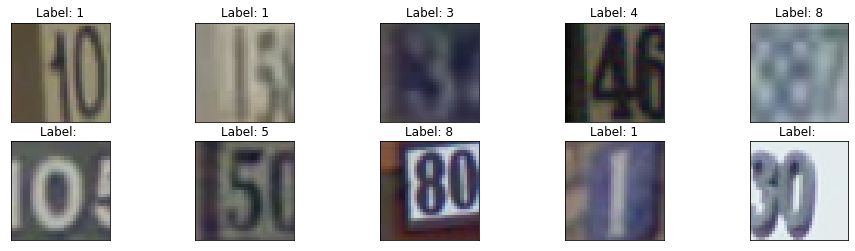

In [14]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [15]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [16]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [17]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[3632, 9145, 19942, 20068, 20333, 22670, 37933, 43698, 56523, 65475]


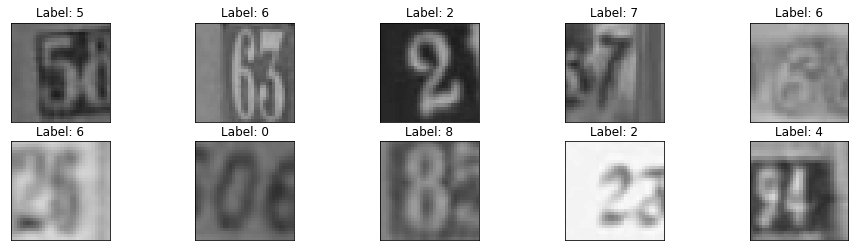

In [18]:
plot_sample_grey(10)

In [19]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


Let us do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

In [20]:
# # let's do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

def get_model_seq(input_shape):
    model = Sequential([
                Flatten(name='F1',input_shape=input_shape),
                Dense(128, activation='relu', 
                      name = 'D1'),
                Dense(128, activation='relu', name = 'D2'),
                Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D4R'),                
                Dense(10,  activation='softmax', name = 'SFTMX1')
    ])    
    return model

model_seq = get_model_seq(train_data_grey[0,:,:,:].shape)

# model_seq.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# callbacks_seq = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
#                            mode='max',
#                            patience=60)
#                 ]

# history_seq = model_seq.fit(  train_data_grey, 
#                       train_targets,
#                       epochs=500, 
#                       validation_data=(validation_data_grey, validation_targets),
#                       callbacks=callbacks_seq,
#                       batch_size=512)

# plot_history(history_seq)
# model_seq.evaluate(test_data_grey,test_targets)

model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 F1 (Flatten)                (None, 1024)              0         
                                                                 
 D1 (Dense)                  (None, 128)               131200    
                                                                 
 D2 (Dense)                  (None, 128)               16512     
                                                                 
 D4R (Dense)                 (None, 48)                6192      
                                                                 
 SFTMX1 (Dense)              (None, 10)                490       
                                                                 
Total params: 154,394
Trainable params: 154,394
Non-trainable params: 0
_________________________________________________________________


In [21]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [22]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [23]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)

Some functions to get scores on the results

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [25]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [26]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

# basic model functions for GP

In [27]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

In [28]:
def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  # Convolutional Layer #1
  c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

  # Pooling Layer #1
  mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
  c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
  #with tf.name_scope('Pool2 Layer'):
  mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
  f1_output = Flatten(name='F1')(mxp2_output)

  # Dense Layer
  d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
  drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
  model = Model(base_input, model_output, name = model_name)
  return model

In [29]:
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization


In [30]:
def basic_ResNet50Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(ResNet50(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)

def basic_VGG19Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(VGG19(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)



In [31]:
import uuid
# uuid.uuid4()
# str(uuid.uuid4()).split("-")[0]

In [32]:
# https://github.com/asmith26/wide_resnets_keras

# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride, identifier, 
                channel_axis = -1,
                weight_decay = 0.0005,
                weight_init="he_normal",
                use_bias = False,
                dropout_probability = 0.0
                ):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name = f"CONV0_{identifier}_{uuid.uuid4()}")(convs)
            else:
                convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability, name=f"DRP{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name=f"CONV{str(i)}_{identifier}_{uuid.uuid4()}")(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=L2(weight_decay),
                              use_bias=use_bias,
                              name=f"CONVSHORTCUT_{identifier}_{uuid.uuid4()}")(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


In [33]:
def model_combination_of_features(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


def model_combination_of_features_with_flatten(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Flatten(),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model    


# X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
# X_train_new = np.concatenate(tuple(X_trains_out), axis=1)


In [34]:
def get_features_for_layer(feature_files, layer_name, num_of_models, axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  validation_features_to_load = sorted(random.sample(feature_files_used, min(num_of_models,len(feature_files_used)) ))
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab



In [35]:
import gpflow
from gpflow.utilities import ops, print_summary, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

import random
import os,sys
import numpy as np
import pandas as pd
from plotnine import *
from matplotlib import pyplot  as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [36]:
import inspect
  
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
 
def mod_retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
 
def foo(bar):
	print(retrieve_name(bar))
	print(mod_retrieve_name(bar))

# x,y,z = 1,2,3
# foo(x)

Setup the GP-specific data structure for the DNN/CNN/WideResNet softmax features

In [37]:
def setup_feature_data_for_gp(np_x_train_collab, np_x_test_collab, train_targets, test_targets):
  
  num_of_data_points = np_x_train_collab.shape[0] 
  num_classes = np.unique(train_targets[:num_of_data_points,:]).size
  num_of_functions = num_classes
  num_of_independent_vars = np_x_train_collab.shape[-1]
  num_of_test_data_points = min(num_of_data_points,test_targets.shape[0])

  data_gp_train = np_x_train_collab[:num_of_data_points,:]
  data_gp_test = np_x_test_collab[:num_of_test_data_points,:]

  data_gp_train_target_hot = np.squeeze(np.eye(num_classes)[train_targets[:num_of_data_points,:]].astype(bool))
  data_gp_train_target = np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot)
  data_gp_train_target = np.expand_dims(data_gp_train_target, axis=1)

  data_gp_test_target_hot = np.squeeze(np.eye(num_classes)[test_targets[:num_of_test_data_points,:]].astype(bool))
  data_gp_test_target = np.apply_along_axis(np.argmax, 1, data_gp_test_target_hot)
  data_gp_test_target = np.expand_dims(data_gp_test_target, axis=1)

  data_gp = ( data_gp_train, data_gp_train_target )
  return data_gp, data_gp_test, data_gp_test_target


In [38]:
def construct_kernel_list(num_of_independent_vars, base_lengthscales = [1.0]):
  possible_kernels = []
  for i in range(len(base_lengthscales)):
    possible_kernels.append(gpflow.kernels.Matern12(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.Matern32(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.RBF(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.Matern52(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.SquaredExponential(lengthscales=[base_lengthscales[i]]*num_of_independent_vars))  

  return possible_kernels

In [39]:
 def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [40]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [41]:
def get_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  np_x_test_collab = None
  for base_val_str in [ ff.replace("Validation","Test") for ff in base_patterns_for_validations]:
      test_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
      np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)
      if np_x_test_collab is None:
        np_x_test_collab = np_x_test_collab_batch.copy()
      else:
        np_x_test_collab = np.concatenate([np_x_test_collab, np_x_test_collab_batch], axis=axis_to_concat)

  np_x_train_collab = None
  for base_val_str in [ ff.replace("Validation","Train") for ff in base_patterns_for_validations]:
      train_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
      np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)
      if np_x_train_collab is None:
        np_x_train_collab = np_x_train_collab_batch.copy()
      else:
        np_x_train_collab = np.concatenate([np_x_train_collab, np_x_train_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

In [42]:
import numpy as np
import pandas as pd
import os,sys

def run_gpset_directly_on_input( type_name,
                              data_gp, 
                             data_gp_test,
                             data_gp_test_target,
                             id_str,
                             num_of_models,
                             nth_inducing_ratio = 120, 
                             var_list = [1.0],       
                             early_stop_count = 100,
                             early_stop_check_interval = 1000,
                             early_stop_elbo_factor = 1.0001,
                             max_niters = 200000, ):

  num_of_independent_vars = data_gp[0].shape[1]
  num_of_classes = np.unique(data_gp[1]).size
  num_of_functions = num_of_classes
  possible_kernels = construct_kernel_list(num_of_independent_vars, var_list)
  # Robustmax Multiclass Likelihood
  invlink = gpflow.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gpflow.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  idxs_of_induced = sorted(random.sample(range(data_gp[0].shape[0]),int(data_gp[0].shape[0]/nth_inducing_ratio)))
  inducing_inputs = data_gp[0][idxs_of_induced,:].copy()  # inducing inputs
  gp_models = []
  for kernel in possible_kernels:
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_inputs,
        num_latent_gps=num_of_functions,
        whiten=True,
        q_diag=True,
    )
    # Only train the variational parameters
    # set_trainable(m.kernel.kernels[1].variance, False)
    set_trainable(m.inducing_variable, True)
    gp_models.append(m)
  result_dict = dict()

  df_to_return = None
  idxCount = 0 
  for mcount,m in enumerate(gp_models):

      print(mcount)
      tensor_data = tuple(map(tf.convert_to_tensor, data_gp))
      training_loss = m.training_loss_closure(tensor_data, compile=True)
      starting_elbo = -training_loss().numpy()
      print(f'Starting ELBO {starting_elbo}')
      elbos = [training_loss().numpy()]
      optimizer = tf.optimizers.Adam()  

      # optimizer = tf.optimizers.RMSprop()
      @tf.function
      def optim_here():
          optimizer.minimize(training_loss, m.trainable_variables)

      try:
        for itc in range(max_niters):
            optim_here()
            elbo_now = -training_loss().numpy()
            elbos.append(elbo_now)
            if (itc % early_stop_check_interval) == 0:
              print(f'ELBO {elbo_now}')
              if len(elbos) > (early_stop_count+1):
                if elbos[-early_stop_count] >= elbos[-1]*early_stop_elbo_factor:
                    print(f'Early stopping at {itc}')
                    break          
            # needs at least a decent improvement

        print(f'Ending ELBO {elbos[-1]}')

        y_pred_model, y_pred_model_V = m.predict_y(data_gp_test)  
        y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
        pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
        print (gp_models[mcount].kernel.name, mcount, pr, rc, f1, acc)

        if df_to_return is None:
          df_to_return = pd.DataFrame({"Type": type_name,
                      "Data" : "Test",
                      "NumOfModels": num_of_models,
                      "GPName": gp_models[mcount].kernel.name,
                      "Pr": pr,
                      "Rc": rc,
                      "F1": f1,
                      "Acc": acc,
                      }, index = [idxCount])
        else:
          df_to_return = pd.concat([df_to_return, pd.DataFrame({"Type": type_name,
                      "Data" : "Test",
                      "NumOfModels": num_of_models,
                      "GPName": gp_models[mcount].kernel.name,
                      "Pr": pr,
                      "Rc": rc,
                      "F1": f1,
                      "Acc": acc,
                      }, index = [idxCount])])
        
        # # result_dict[f"{gp_models[0].kernel.name}_{mcount}_{id_str}"] = dict({'model': m, 'X': data_gp_test, 'Y': data_gp_test_target, 'pY': pY, 'pYv': pYv})
        # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_{id_str}_Test_{gp_models[mcount].kernel.name}_{mcount}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        #     np.array(pY), 
        #     allow_pickle=True, 
        #     fix_imports=True)
        # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_{id_str}_Test_Targets_{gp_models[mcount].kernel.name}_{mcount}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        #     np.array(data_gp[1]), 
        #     allow_pickle=True, 
        #     fix_imports=True)
        # tf.saved_model.save(m, f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_{id_str}_model_{gp_models[mcount].kernel.name}_{mcount}_{datetime.datetime.now():%Y%m%d%H%M%S}")
        # print_summary(m, fmt="notebook")  
      except:
        print(f'ERROR, Ending ELBO {elbos[-1]} (NOT saved)')
        next

  return df_to_return # result_dict


# Set up the models + features file lists for CNN/DNN/ResNet50/WideResNet28-10 splits for reuse SVHN

In [43]:
acceptable_string_grabs = [ "CNN_A_", "DNN_A_", "RestNet50_A_", "WideResNet28-10_ID"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_model_dirs = [ s for s in model_dirs if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_model_dirs = [ s for s in model_dirs if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_features_files = [ s for s in model_features_files if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_features_files = [ s for s in model_features_files if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]
# dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
# cnn_layer_name = "D3R"

wideresnet_identifier = acceptable_string_grabs[3]
# wideresnet_layer_name = "CLASSIFIER_FL"


def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




# Data for GP collaborative model on DNN softmax layer 

In [ ]:
num_of_models_to_test = [2,5,10,15,20,25,30,35,40]
num_of_repeats = 1
layer_name_sftmx_dnn = "SFTMX1"
gp_df_dnn = None


In [ ]:
for repc in range(num_of_repeats):
  for num_of_models in num_of_models_to_test:
    np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files, layer_name_sftmx_dnn, num_of_models)
    data_gp_dnnf, data_gp_test_dnnf, data_gp_test_target_dnnf = setup_feature_data_for_gp(np_x_train_collab_dnn,  np_x_test_collab_dnn, train_targets, test_targets   )
    layer_name_sftmx_dnn = "SFTMX1"
    df_test_here = run_gpset_directly_on_input("DNN",
                                               data_gp_dnnf, 
                                data_gp_test_dnnf,
                                data_gp_test_target_dnnf,
                                f"Collab_GP_DNN_{layer_name_sftmx_dnn}_ID{str(uuid.uuid4()).split('-')[0]}",
                                num_of_models,
                                nth_inducing_ratio = 120, 
                                var_list = [1.0],       
                                early_stop_count = 100,
                                early_stop_check_interval = 1000,
                                early_stop_elbo_factor = 1.0001, # 1.0001,
                                max_niters = 200000
                                )
    # df_test_here.loc[max(df_test_here.index)]
    print(df_test_here)
    if gp_df_dnn is None:
      gp_df_dnn = df_test_here
    else:
      gp_df_dnn = pd.concat([gp_df_dnn,df_test_here], ignore_index=True)  
    gp_df_dnn.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/Collab_gp_tempdensenn_test_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



0
Starting ELBO -600298.2439976931
ELBO -599909.2349722395
ELBO -106719.1002492206
ELBO -104440.40751388026
ELBO -103501.51905389775
ELBO -102820.01729590562
ELBO -102256.74346272506
ELBO -101757.68128078265
ELBO -101337.94693336822
ELBO -101034.01084888761
ELBO -100779.63160039228
ELBO -100584.81128106349
ELBO -100462.4437811274
Early stopping at 11000
Ending ELBO -100462.4437811274
matern12 0 0.8677945012161182 0.8674 0.8673701736450106 0.8674
  Type  Data  NumOfModels    GPName        Pr      Rc       F1     Acc
0  DNN  Test            2  matern12  0.867795  0.8674  0.86737  0.8674
0
Starting ELBO -600298.2439976931
ELBO -599827.7627737165
ELBO -90164.98899217858
ELBO -84669.22097623699
ELBO -82750.81917130113
ELBO -81544.11581280999
ELBO -80602.53399766382
ELBO -79806.1876033453
ELBO -79146.25758853428
ELBO -78616.00501897934
ELBO -78214.25406393723
ELBO -77915.95930198392
ELBO -77672.89659756904
ELBO -77493.23050516294
ELBO -77359.83964461717
ELBO -77265.01635599544
Early stopping

In [ ]:
gp_df_dnn.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/Collab_gp_densenn_test_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for GP collaborative model on WideResNet softmax layer 

In [ ]:
num_of_models_to_test = [7,8,9,10,11,12]
num_of_repeats = 1
layer_name_sftmx_wideresnet = "CLASSIFIER_D1"

gp_df_wrn = None


In [ ]:
# len(wideresnets_features_files)

1080

In [ ]:
for repc in range(num_of_repeats):
  for num_of_models_wideresnets in num_of_models_to_test:
    
    np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnet,num_of_models_wideresnets,model_type="WideResNet")
    data_gp_wrn, data_gp_test_wrn, data_gp_test_target_wrn = setup_feature_data_for_gp(np_x_train_collab_wideresnets,  np_x_test_collab_wideresnets, train_targets, test_targets   )
    
    df_test_here = run_gpset_directly_on_input(data_gp_wrn, 
                                data_gp_test_wrn,
                                data_gp_test_target_wrn,
                                f"Collab_GP_WideResNet_{layer_name_sftmx_wideresnet}_ID{str(uuid.uuid4()).split('-')[0]}",
                                num_of_models_wideresnets,
                                nth_inducing_ratio = 120, 
                                var_list = [1.0],       
                                early_stop_count = 100,
                                early_stop_check_interval = 1000,
                                early_stop_elbo_factor = 1.0001, # 1.0001,
                                max_niters = 200000
                                )
    # df_test_here.loc[max(df_test_here.index)]
    print(df_test_here)
    if gp_df_wrn is None:
      gp_df_wrn = df_test_here
    else:
      gp_df_wrn = pd.concat([gp_df_wrn,df_test_here], ignore_index=True)  
    gp_df_wrn.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/Collab_gp_tempWideResNet_test_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")





In [ ]:
gp_df_wrn.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/Collab_gp_WideResNet_test_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for GP collaborative model on CNN softmax layer 

In [ ]:
num_of_models_to_test = [15,20,25,30,35,40]
num_of_repeats = 1
layer_name_sftmx_cnn = "SFTMX1"
gp_df_cnn = None


In [ ]:
for repc in range(num_of_repeats):
  for num_of_models in num_of_models_to_test:
    np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files, layer_name_sftmx_cnn, num_of_models)
    data_gp_cnnf, data_gp_test_cnnf, data_gp_test_target_cnnf = setup_feature_data_for_gp(np_x_train_collab_cnn,  np_x_test_collab_cnn, train_targets, test_targets   )
    df_test_here = run_gpset_directly_on_input("CNN", 
                                               data_gp_cnnf, 
                                data_gp_test_cnnf,
                                data_gp_test_target_cnnf,
                                f"Collab_GP_DNN_{layer_name_sftmx_cnn}_ID{str(uuid.uuid4()).split('-')[0]}",
                                num_of_models,
                                nth_inducing_ratio = 120, 
                                var_list = [1.0],       
                                early_stop_count = 100,
                                early_stop_check_interval = 1000,
                                early_stop_elbo_factor = 1.0001, # 1.0001,
                                max_niters = 200000
                                )
    # df_test_here.loc[max(df_test_here.index)]
    print(df_test_here)
    if gp_df_cnn is None:
      gp_df_cnn = df_test_here
    else:
      gp_df_cnn = pd.concat([gp_df_cnn,df_test_here], ignore_index=True)  
    gp_df_cnn.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/gp_tempcnn_sftmx_test_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")





0
Starting ELBO -600298.2439976931
ELBO -599913.2035844065
ELBO -6434.169290862274
ELBO -2797.93720500409
ELBO -1891.2476898796886
ELBO -1493.6623062324936
ELBO -1255.0942038377984
ELBO -1075.5036231683262
ELBO -908.7561171790471
ELBO -766.3218623365962
ELBO -645.9185160149754
ELBO -581.6316658347955
ELBO -543.2057187837462
ELBO -521.7738375504497
ELBO -502.58900295126404
ELBO -483.0678773090218
ELBO -464.8219485689798
ELBO -450.22098912961366
ELBO -439.7937974069678
ELBO -433.65027894324226
ELBO -427.6989245072976
ELBO -423.819634843587
ELBO -420.5188801359327
ELBO -417.1134449110766
ELBO -414.48245862066403
ELBO -412.23382328928426
ELBO -410.2309506143237
ELBO -408.43457223782514
ELBO -406.74801084441884
ELBO -405.17291833297946
ELBO -403.8249156008169
ELBO -402.62953401325626
ELBO -401.49897285755077
ELBO -400.500048391047
ELBO -399.58084282681784
ELBO -398.7337245857457
ELBO -397.92973318147267
ELBO -397.1884339970043
ELBO -396.49598019494
ELBO -395.85793945740704
ELBO -395.2612147

In [ ]:
gp_df_cnn.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/Collab_gp_sftmx_cnn_test_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


NameError: ignored

# Analysis




In [44]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


# Superlearner Setup

In [47]:
%load_ext rpy2.ipython

SyntaxError: ignored

In [ ]:
%%R 
install.packages(c("tidyverse","data.table","foreach","MASS","h2o","ggplot2","ggthemes","esquisse"), quiet=TRUE, verbose=FALSE)

In [49]:
%%R
install.packages(c("nnls","quadprog","SuperLearner"),quiet=T, verbose=F)

R[write to console]: also installing the dependencies ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’, ‘gam’, ‘cvAUC’




# 